In [1]:
import numpy as np
import torch
import torch.nn as nn
import math
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from IPython import display

#### Vision Transformers

This notebook will run through an example of a vision transformer. So far, we have seen how the convolution operation can be used to respond to find spatially invariant features in images, in effect acting like a learnable image filter. This is particularly powerful in learning the local texture and frequency changes that help us recognise or identify things in images.

However, these operations are not great at bringing in global context. For example, if you wanted to predict the pose of a partially occluded human in an image, seeing the location of the head, an arm or a leg is really useful information or context to inform the location of the full body pose. CNNs use fully connected layers to try to pull in this global context, but we can be more explicit about it using attention, the key mechanism behind a transformer.

Lets explore this with the CIFAR10 dataset, a set of small 32x32 images from one of 10 classes. Our goal will be to learn to predict the image class.

In [2]:
# Lets set up some transformations to provide some data augmentation
transforms_train = transforms.Compose([
	transforms.RandomCrop(32, padding=4),
	transforms.RandomHorizontalFlip(),
	transforms.ToTensor(),
	transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# We won't used these for testing
transforms_test = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# We'll set up data loaders using pytorch
cf_train = datasets.CIFAR10(root='./data/',train=True,download=True,transform=transforms_train)
cf_test = datasets.CIFAR10(root='./data/',train=False,download=True,transform=transforms_test)

# Let's choose some parameters for the model
patch_size = 4 #I want my patches to be 4x4 pixels large
num_patches = (32//patch_size)**2 # For 32x32 dim images, that means we have n patches 
batch_size = 128 # I will use a batch size of 128 to train my model

trainloader = DataLoader(cf_train,batch_size=batch_size,shuffle=True,pin_memory=True,num_workers=8)
testloader = DataLoader(cf_test,batch_size=batch_size,shuffle=True,pin_memory=True,num_workers=8)


100%|██████████| 170498071/170498071 [00:13<00:00, 12892230.89it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


Let's take a quick look at our data. Re-run the cell below a couple times to see a few random samples from the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


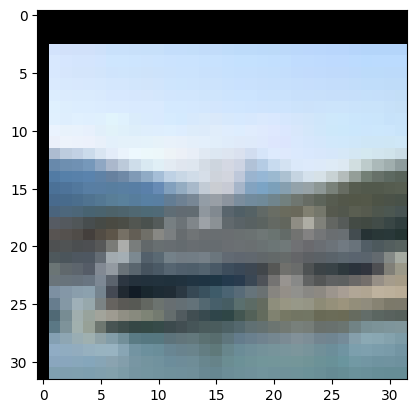

In [3]:
#Sanity check on data - it gives us some images, but they've been normalised so we can't really make out much in them
ims,classes= next(iter(trainloader))
plt.imshow(ims[0,:,:,:].transpose(0,2).transpose(0,1)*np.array([0.2023, 0.1994, 0.2010])+np.array([0.4914, 0.4822, 0.4465]))
plt.show()

The first thing we will need for our vision transformer is a patch embedder. This will break our images into different patches, to help us better capitalise on the global context in the image to make decisions. The [original vision transformer](https://arxiv.org/pdf/2010.11929v2.pdf) breaks an image into 16x16 patches, but we chose a smaller number because our CIFAR10 images are quite small.

*Dosovitskiy et. al, An image is worth 16x16 Words: Transformers for Image Recognition at Scale, ICLR 2021*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

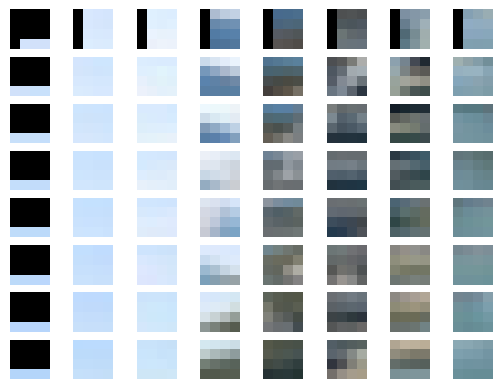

In [4]:
for i in range(32//patch_size):
    for j in range(32//patch_size):
        plt.subplot(32//patch_size,32//patch_size,32//patch_size*i+j+1)
        # Note that we transpose here because torch expects channel x dim x dim images
        plt.imshow(ims[0,:,patch_size*j:patch_size*(j+1),patch_size*i:patch_size*(i+1)].transpose(0,2).transpose(0,1)*np.array([0.2023, 0.1994, 0.2010])+np.array([0.4914, 0.4822, 0.4465])) 
        plt.axis('off')
plt.show()

Our patch embedder does this, and uses a linear projection to convert each patch into and embedding (feature) vector. Note that this removes the typical ***inductive bias*** associated with convolution - no knowledge of spatial pixel information ***within*** the patch is provided. If you want both, maybe you need to use a few fully convolutions on the entire image to extract this information first, before patch embedding.

In [5]:
class PatchEmbedder(nn.Module):
    
    def __init__(self,dim=768,patch_size=20):
        super(PatchEmbedder,self).__init__()
        """
        Split the word into patches using a strided convolution operation
        This operation turns each patch into a 768 dimensional vector
        """
        self.model = nn.Conv2d(3,dim,kernel_size=(patch_size,patch_size),stride=(patch_size,patch_size))
        self.dim = dim
        
    def forward(self,x):
        
        patches = self.model(x)
        
        return patches.flatten(2) #flatten all the patches into one long vector

In [6]:
# Sanity check on patch embedder - the size here should produce batch x d x # patches
PatchEmbedder(patch_size=patch_size)(ims).shape

torch.Size([128, 768, 64])

Our patch embedding is going to be combined with a positional embedding - a unique, learnable code that is used to help the network keep track of which patch this embedding corresponds to.

In [7]:
class PosEmbedder(nn.Module):
    
    def __init__(self, dim=768, num_patches=6,p=0.5):
        super().__init__()
        
        self.pos_enc = nn.Parameter(torch.randn(1,num_patches,dim),requires_grad=True) # These positional encodings are learned nn.Parameter is trainable
        self.dropout = nn.Dropout(p=0.5)
    def forward(self,x):
        
        return self.dropout(x + self.pos_enc) #Add input and positional encoding 
        

In [8]:
''' 
Sanity check on pos encoder - the size here should produce batch x # patches x d
Note that we transpose our patch embeddings first before adding the positional encodings
This will help us later with the attention mechanism we build
'''
PosEmbedder(num_patches=num_patches)(PatchEmbedder(patch_size=patch_size)(ims).transpose(1,2)).shape

torch.Size([128, 64, 768])

Now we'll implement the key part of our vision transformer, a self attention block. This takes an input and passes it through 3 separate linear layers to generate a query, key and value feature vector. The inner product between the query and key vectors is used to produce an *attention* matrix that passes key value information along in the network. 

Each attention block will perform this operation a few times, using multiple attention heads. We term this *multi-head attention*. With some clever reshaping, we can perform multi-head attention using a single operation.

In [9]:
class AttentionBlock(nn.Module):
    def __init__(self, dim=768,dim_head=64,heads=8,p=0.):
        super().__init__()
        
        self.heads = heads
        
        self.out = nn.Sequential(nn.Linear(dim_head*heads,dim),
                                nn.Dropout(p))
            
        self.norm = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(p=p)
        self.attention = nn.Softmax(dim=-1)
        
        # This is done with one operation, but could be separated
        self.qkv = nn.Linear(dim,dim_head*heads*3,bias=False)
            
        self.scale = dim_head**-0.5
        
    def forward(self,x):
        
        xn = self.norm(x)
        
        '''
        We are implementing multi-head self attention so a few steps are needed here:
        * Get query, key and value (batch x patches+1 x #heads*head dim*3) 
        * Reshape to batch x patches+1 x heads x head_dim*3
        * Swap head and patch dims
        * Split into query, key and value dims
        * Each embedding is now batch x heads x patches+1 x head_dim                                  
        '''                            
        
        q,k,v = self.qkv(xn).reshape(x.shape[0],x.shape[1],self.heads,-1).transpose(1,2).chunk(3,dim=-1)
        
        '''
        We'll implement scale dot product attention:
        * Compute inner product between query and k and scale
        * Attention matrix is now batch x heads x patches+1 x patches+1
        '''
        attn = (self.dropout(self.attention(q@k.transpose(-2,-1)*self.scale)))
        
        '''
        Compute attention score for each head
        * Score is batch x heads x patches+1 x head_dim
        * Swap heads and patch dim
        * Collapse heads to single embedding, batch x patches+1 x heads*head_dim
        
        '''
        score = (attn@v).transpose(1,2).reshape(x.shape[0],x.shape[1],-1)
        
        # Pass through linear layer to restore to hidden dim 
        return self.out(score)
    
    def get_attention(self,x):
        
        xn = self.norm(x)
        q,k,v = self.qkv(xn).reshape(x.shape[0],x.shape[1],self.heads,-1).transpose(1,2).chunk(3,dim=-1)
        attn = (self.dropout(self.attention(q@k.transpose(-2,-1)*self.scale)))
        score = (attn@v).transpose(1,2).reshape(x.shape[0],x.shape[1],-1)
        
        # Pass through linear layer to restore to hidden dim 
        return self.out(score), attn

Our attention block will be paired with an MLP head

In [10]:
class MLP(nn.Module):
    def __init__(self, dim=768,hidden_dim=64,p=0.):
        super().__init__()
        
        self.net = nn.Sequential(nn.LayerNorm(dim),
                                 nn.Linear(dim,hidden_dim),
                                 nn.GELU(),
                                 nn.Dropout(p),
                                 nn.Linear(hidden_dim,dim),
                                 nn.GELU(),
                                 nn.Dropout(p))
        
    def forward(self,x):
        return self.net(x)

We combine these blocks, adding layer normalisation and skip connections, to produce a *Transformer*.

In [11]:
class Transformer(nn.Module):
    def __init__(self, dim=768,dim_head=64,heads=8,hidden_dim=128,p=0.):
        super().__init__()
        
        # nromalises over last dim dimensions
        self.norm = nn.LayerNorm(dim)
        
        self.attn = AttentionBlock(dim=dim,heads=heads,dim_head=dim_head,p=p)
        self.ff = MLP(dim=dim,hidden_dim=hidden_dim,p=p)
        
    def forward(self,x):
        
        # skip connections
        x = self.attn(x) + x
        x = self.ff(x) + x

        return self.norm(x)
    
    def get_attention(self,x):
        
        # skip connections
        xo,amap = self.attn.get_attention(x)
        
        x = xo + x
        x = self.ff(x) + x

        return self.norm(x), amap
    
    
            

Ok, let's use these to build our Vision Transformer. This will positionally encode a patch embedder, then pass it through a series of Transformers before moving to a classification layer. There is one more tweak though. To aid classification, we will add a token to the list of patches that will be used for classification. So our transformer will be trained to link patches to this token to make classification decisions.

In [12]:
class VisionTransformer(nn.Module):
    
    def __init__(self,dim=768,patch_size=16,n_classes=6,num_patches=6,layers=1,heads=8,dim_heads=64,hidden_dim=128,p=0.0):
        super().__init__()
        
        self.patchifier = PatchEmbedder(dim=dim,patch_size=patch_size)
        self.position_encoder = PosEmbedder(dim=dim,num_patches=num_patches+1)
        tf_list = nn.ModuleList([Transformer(dim=dim,dim_head=dim_heads,heads=heads,hidden_dim=hidden_dim,p=p) for n in range(layers)])
        self.transformer = nn.Sequential(*tf_list)
        
        self.layers = layers
        
        # Add a trainable token for classification
        self.cls_token = nn.Parameter(torch.randn(1,1,dim))
        
        self.classifier = nn.Linear(dim,n_classes)
        self.layers = layers
        
        self.dropout = nn.Dropout(p)
        
    def forward(self,im):
        
        patch_embeddings = self.patchifier(im)
        
        # Extend the patch embeddings to add the class token to the patches
        v = torch.cat((self.cls_token.expand(patch_embeddings.shape[0],-1,-1).transpose(1,2),patch_embeddings),dim=-1)
        # Positionally encode
        pos_encodings = self.position_encoder(v.transpose(1,2))
        # Transformer
        x = self.transformer(self.dropout(pos_encodings))
        # Return the classifier decision made using our class token [bin 0]
        return self.classifier(x[:,0,:])
    
    def show_attention(self,im):
        
        patch_embeddings = self.patchifier(im)
        
        # Extend the patch embeddings to add the class token to the patches
        v = torch.cat((self.cls_token.expand(patch_embeddings.shape[0],-1,-1).transpose(1,2),patch_embeddings),dim=-1)
        # Positionally encode
        x = self.position_encoder(v.transpose(1,2))
        
        att_list = []
        for i in range(self.layers):
            x,attn = self.transformer[i].get_attention(self.dropout(x))
            att_list.append(attn)
        
        return att_list

Let's setup and train our vision transformer on the CIFAR10 data.

In [13]:
# Set up our model and training details
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
layers = 2
heads = 6
dim = 384


VIT = VisionTransformer(dim=dim,patch_size=patch_size,n_classes=10,heads=heads,num_patches=num_patches,layers=layers,hidden_dim=dim,p=0.5).to(device)
opt = torch.optim.AdamW(VIT.parameters(),lr=1e-4,weight_decay=1e-5)

loss_fn = nn.CrossEntropyLoss()# Use a cross entropy classification loss

Nepochs = 1000

This can be quite slow without a GPU. While it trains we will visualise the attention maps our model learns.

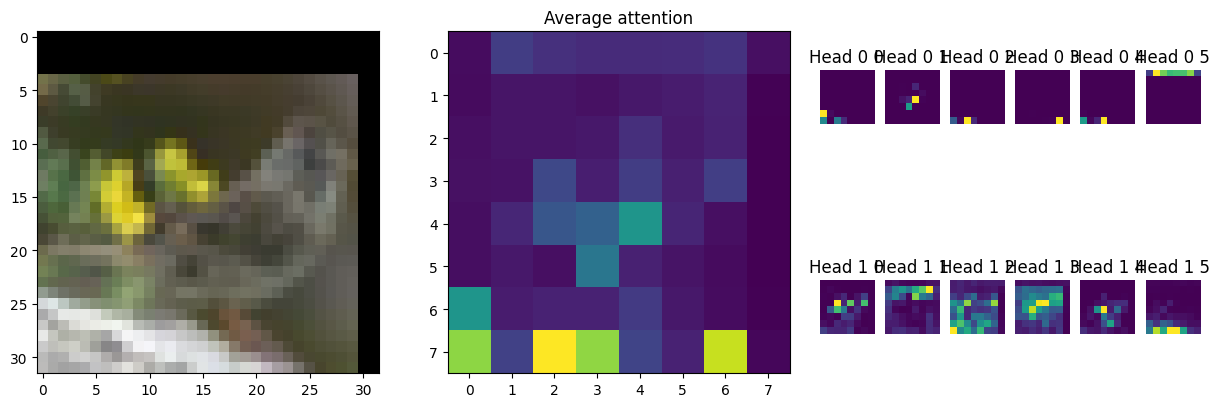

Epoch 999: Loss: 0.93
Epoch 999: Train Accuracy: 0.67
Epoch 999: Validation Accuracy: 0.67


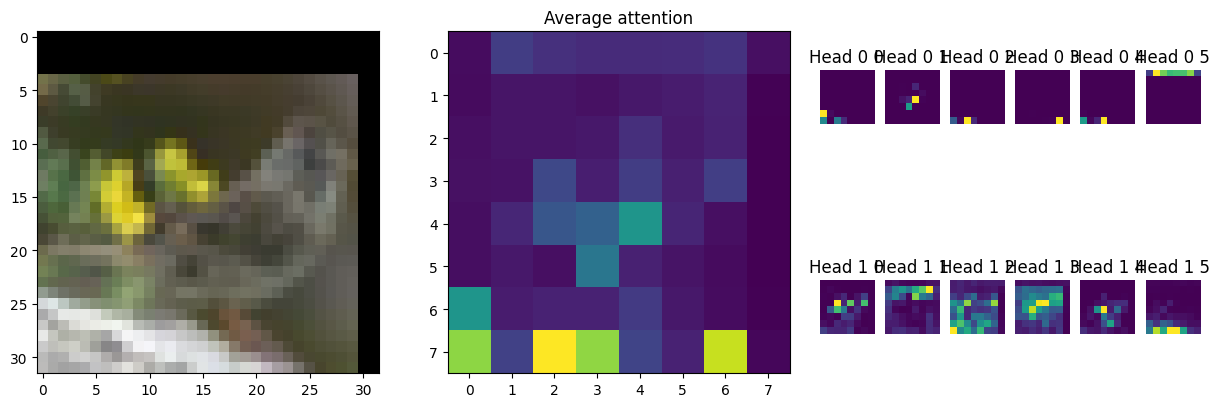

In [14]:
# Training
plt.figure(figsize=(15,5))
for epoch in range(Nepochs):
    
    VIT.train() # Make model trainable
    
    losses = []
    total_len = 0
    correct = 0
    # Iterate over batches in training set
    for ims,counts in trainloader:
        
        predictions = VIT(ims.to(device))
        
        opt.zero_grad() # zero previous gradients
        
        loss = loss_fn(predictions,counts.to(device))
        
        loss.backward() # compute gradient of model parameters with respect to output
        
        correct += (nn.functional.softmax(predictions,dim=-1).argmax(dim=-1)==counts.to(device)).sum().cpu()
        total_len += counts.shape[0]    
        
        torch.nn.utils.clip_grad_norm_(VIT.parameters(), 0.1)
        
        opt.step()
        losses.append(loss.item())
    
    VIT.eval() # Put model in eval mode
    
    # Lets visualise our learned attention maps
    plt.clf()
   
    plt.subplot(1,3,1)
    # Un-normalise the images to make it easier to visualise
    plt.imshow(ims[0,:,:].transpose(0,2).transpose(0,1)*np.array([0.2023, 0.1994, 0.2010])+np.array([0.4914, 0.4822, 0.4465]))
    # Extract attention maps, there will be layers x heads maps
    att_list = VIT.show_attention(ims.to(device)) 
    ave_attention = np.zeros((32//patch_size,32//patch_size))
    for i in range(len(att_list)):
        for j in range(att_list[i].shape[1]):
            plt.subplot(layers,3*heads,(3*i+2)*heads+j+1)   
            '''
            Some complicated indexing here. 
            Each attention map is batch x heads x n_patches+1 x n_patches+1
            The +1 was for the classifier token
            We will select a head, and the attention the classifier token paid to the patches
            We will reshape that to an n patches x n patches saliency map
            ''' 
            att = att_list[i][0,j,0,1:].reshape(32//patch_size,32//patch_size).detach().cpu().numpy()
            
            ave_attention += att
            plt.imshow(att)
            plt.title('Head %d %d'%(i,j))
            plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(ave_attention/(heads*layers))
    plt.title('Average attention')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    # Log some data
    print("Epoch %d: Loss: %2.2f"%(epoch,np.mean(losses)))
    print("Epoch %d: Train Accuracy: %2.2f"%(epoch,correct/total_len))
    
    # Check test set performance
    correct = 0
    total_len = 0
    for ims, counts in testloader:
        total_len += counts.shape[0]    
        predictions = nn.functional.softmax(VIT(ims.to(device)),dim=-1)
        correct += (predictions.argmax(dim=-1)==counts.to(device)).sum().cpu()
    print("Epoch %d: Validation Accuracy: %2.2f"%(epoch,correct/total_len))
    
        

### Activity

Hmmm, accuracy is not amazing... 

* Try make the model deeper, increase the heads and embedding dimensionality. 
* What happens to model performance? 
* Transformers work best when pre-trained on extremely large datasets, before being fine tuned. Why do you think this is? 

*Hint*: remember what we said about inductive biases above, and think about the engineering tradeoffs of structure vs data
